# Run Experiments on our Data


---
```
: zach.wolpe@medibio.com.au
: 09.07.24
```
---


---
# 0. Imports & Config
---

In [1]:
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import pandas as pd

import numpy as np
import statistics
import scipy.io
import logging
import pprint
import os
from collections import Counter
import time
import sys

import mlflow
# internals
from src.helpers import log_rat_metadata, log_sequence_data, load_config
from src.query_dataset import (QuerySequenceData, load_data)

In [2]:
from src.rescorla_wagner_model import (RoscorlaWagner)
from src.rescorla_wagner_model_plots import (RescorlaWagnerPlots)
from src.rescorla_wagner_model_simulation import (RescorlaWagnerSimulate)
from src.rescorla_wagner_model_diagnostics import (RoscorlaWagerModelDiagnostics)

In [3]:
from src.cog_sci_random_response_model import (RandomResponseModel)
from src.cog_sci_win_stay_lose_shift_model import (WinStayLoseShiftModel)
from src.cog_sci_learning_model_base import (MultiArmedBanditModels)
from src.cog_sci_roscorla_wagner_model import RoscorlaWagnerModel

In [4]:
from src.launch_experiments import (
    # helpers
    print_unique_keys, 
    extract_experiment,
    run_experiment_model_1,
    run_experiment_model_2,
    run_experiment_model_3,
    init_results,
    update_results,
    compute_experiment_features,
    print_progress_bar,
    generate_experiment,
    run_experiment,
    run_experiment_suite,

    # configure experiments
    build_experiment_set_v2,
    configure_mlflow_tracking,

    # filter and select model
    filter_results,
    select_model,
    filter_results_select_model,
    save_results,

    # Data Quality and Optimisation Checks
    extract_experiment_for_data_quality,
    compute_experiment_stats,
    compute_reward_per_session,
    plot_reward_per_session,
    optimize_model_2,
    plot_prob_success,

    # Run data quality check
    run_data_quality_check, 

    # execute experiments
    exe_experiment,
)

In [5]:
logging.basicConfig(level=logging.INFO)

---
# 1. Run Experiment Helpers
----

In [6]:
logging.basicConfig(level=logging.INFO)
np.random.seed(2024) # set seed for reproducibility
_config = load_config('config.yaml') # load yaml config


---
# Previous Subsections


> 2. Configure Experiment
> 3. Filter, Select Model & Save Experiments
> 4. Check Data Quality & Optimisation Space

---
# 5. Instantiate: Run Data Quality Checks
----

INFO:root:StimCode (571): [0. 1.]


INFO:root:RespCode (571): [1. 2. 3. 4.]



    ----------------------------------------
    Experiment:
    -----------

        - subjectID:            422
        - sessionType:          EDS
        - sessionNum:           None
        - n_samples:            9000
        - n_sessions:           15
        - samples_per_session:  600.0
        - avg_reward_rate:      0.74933
    ----------------------------------------
    
N (total):9000 - Reward rates: [0.7083333333333334, 0.7166666666666667, 0.765, 0.8833333333333333, 0.88, 0.9416666666666667, 0.6383333333333333, 0.64, 0.6283333333333333, 0.6933333333333334, 0.6683333333333333, 0.74, 0.74, 0.7416666666666667, 0.855]


INFO:root:StimCode (571): [0. 1.]
INFO:root:RespCode (571): [1. 2. 3. 4.]


Optimisation results: [1.], [1.], 1.0


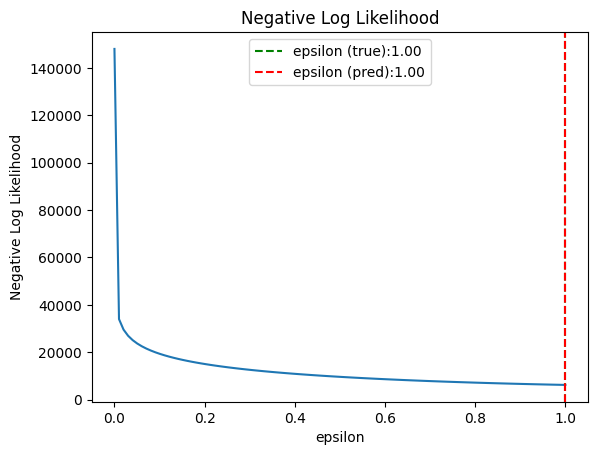

In [7]:
run_data_quality_check(_experiment=(422, 'EDS', None), experiment_class='rat_experiment')

---
# Rat Data: `EDS` Baseline
---

Our two interest groups are defined as follows:


There are 2 types of learning scenarios that we care about in the context of our hypothesis about attention

- **EDS easy**: `EDS` following `EDS_BL_Easy` (labelled _“EDS easy”_)
- **EDS hard**: `EDS` following `EDS_BL_Hard`(labelled _“EDS hard””_)


#### Remove Re-establishment of Attention trails

We know that the re-establishment of attention trails are not useful for our hypothesis. We will remove these from the data.

There are between `100` and `200` re-establishment of attention trails per block. We can assume there are `200` at  this stage, and at a later stage work to determine the exact number.


#### Defining the Interest Groups

- **EDS Easy***

- **EDS Hard***



## Model Proc

1. Fit a baseline models `EDS`, `IDS` for each subject.
    1.a. Assess the best fit architecture per model.
    2.b. Assess the parameter distribution.
2. Fit the `EDS Easy` and `EDS Hard` models for each subject.
    2.a. Assess the best fit architecture per model.
    2.b. Assess the parameter distribution.
3. Compare the difference in parameters between the `EDS Easy`, `EDS Hard`, `IDS_BL_Easy`.

----
# 5. Run Updated Experiment
----

> Group 1: EDS_BL_Easy --> EDS

> Group 2: EDS_BL_Hard --> EDS


Nelson's Notes

- `Adjust` comparison groups
- Paper/s

- IDS_BL_EASY --> Ignore (followed by IDS)
- Ignore: IDS
- Ignore: IDS_BL_EASY
- Ignore: RE (Re-Establish)
- Ignore: Stair (Staircase)
- BL = previous learned stimuli
- Easy = Stimuli left over from what was learned before,


- EDS_BL_Easy : “Easy: ” -> EDS_BL_Easy


#### Groups

- EDS_BL_Easy --> EDS
- EDS_BL_Hard --> EDS

>> EDS 1 vs EDS 2 <<
- Without subjects design
- Compare against baseline
------------------------
Shift cost := baseline!


----
## Load Rat Data

In [8]:
(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='rat_experiment')

print_unique_keys(StimCode)

INFO:root:StimCode (571): [0. 1.]
INFO:root:RespCode (571): [1. 2. 3. 4.]


Unique keys: ['EDS' 'EDS_BL_Easy' 'EDS_BL_Hard' 'IDS' 'IDS_BL_Easy' 'RE' 'Stair']


----
## Extract the Data for each Group

In [9]:
qsd = QuerySequenceData(StimCode, RespCode)
qsd.filter_sequences(
    subjectID=None,
    sessionType=None,
    sessionNum=None,
    update_existing_stim_resp=False)\
    .extract_stim_resp_data()\
    .infer_action_reward_pairs()
qsd

In [10]:
StimCode.keys()

dict_keys([(4151, 'IDS_BL_Easy', 0), (4151, 'IDS_BL_Easy', 1), (4151, 'IDS', 0), (4151, 'IDS', 1), (4151, 'IDS', 2), (4151, 'IDS', 3), (4151, 'IDS', 4), (4151, 'IDS', 5), (4151, 'RE', 0), (4151, 'Stair', 0), (4151, 'Stair', 1), (4151, 'Stair', 2), (4151, 'EDS_BL_Easy', 0), (4151, 'EDS_BL_Easy', 1), (4151, 'EDS', 0), (4151, 'EDS', 1), (4151, 'EDS', 2), (4151, 'EDS', 3), (4151, 'EDS', 4), (4151, 'EDS', 5), (4151, 'EDS', 6), (4151, 'EDS', 7), (4151, 'IDS_BL_Easy', 2), (4151, 'IDS_BL_Easy', 3), (4151, 'IDS', 6), (4151, 'IDS', 7), (4151, 'IDS', 8), (4151, 'RE', 1), (4151, 'Stair', 3), (4151, 'Stair', 4), (4151, 'Stair', 5), (4151, 'EDS_BL_Hard', 0), (4151, 'EDS_BL_Hard', 1), (4151, 'EDS', 8), (4151, 'EDS', 9), (4151, 'EDS', 10), (4151, 'EDS', 11), (4151, 'EDS', 12), (4151, 'EDS', 13), (4151, 'EDS', 14), (4151, 'EDS', 15), (4151, 'EDS', 16), (4151, 'RE', 2), (4151, 'RE', 3), (4152, 'IDS_BL_Easy', 0), (4152, 'IDS_BL_Easy', 1), (4152, 'IDS', 0), (4152, 'IDS', 1), (4152, 'IDS', 2), (4152, 'IDS'

## Extracting the Experiment Structure


We wish to split the experiments into 2 groups over 2 variants.

**Groups**

- EDS_BL_EASY --> EDS
- EDS_BL_HARD --> EDS

**Variants**

We are primarliy interested in the effects of EDS learning. The first stage is only relevant to seperate the groups.

We therefore build experiments by 

****

#### Sample Experiemnt of a Single Rat

```python
x = [i for i in StimCode.keys() if ('EDS' in i[1]) or ('EDS_BL_HARD' in i[1])]
subjects = np.unique([i[0] for i in x])
_subject = np.random.choice(subjects)
print('subject: ', _subject)
[i for i in x if i[0] == _subject]
```

Example Output:

```
[(532, 'EDS_BL_Hard', 0),
 (532, 'EDS_BL_Hard', 1),
 (532, 'EDS', 0),
 (532, 'EDS', 1),
 (532, 'EDS', 2),
 (532, 'EDS_BL_Easy', 0),
 (532, 'EDS_BL_Easy', 1),
 (532, 'EDS', 3),
 (532, 'EDS', 4),
 (532, 'EDS', 5),
 (532, 'EDS', 6),
 (532, 'EDS', 7),
 (532, 'EDS', 8),
 (532, 'EDS', 9),
 (532, 'EDS', 10)]
 ```



### Load New Modules

In [11]:
    # EXPERIMENT_NAME_MLflow = f"RL Experiment - {DATA_SET} - {EXPERIMENT_NAME}"
    # print('DROP_N_TRAILS={} introduced to account for rebasing.'.format(DROP_N_TRAILS))
    # # load data
    # (data,
    #     sequence_data,
    #     meta_data,
    #     StimCode,
    #     RespCode) = load_data(config=_config, experiment_class=EXPERIMENT_CLASS)
    # qsd = QuerySequenceData(StimCode, RespCode)

    # # configure mlflow
    # configure_mlflow_tracking(
    #     mlflow_tracking_dir="./mlruns",
    #     experiment_name=EXPERIMENT_NAME_MLflow
    # )

In [12]:
# load new modules
from src.launch_experiments import (
    build_experiment_set_v3_EDS_post_learning,
    run_experiment_v2,
    exe_experiment_suite_v2)

### > Example: Build Experiments (v2)

In [13]:
# instantiate
build_exp = build_experiment_set_v3_EDS_post_learning(StimCode, RespCode)
experiment_generator = build_exp.generate_experiments()
(
exp_idx,
_subject_ID,
_experiment_class,
qsd,
action_vector,
reward_vector
) = next(experiment_generator)

### > Example: Run a single Experiment (V2)

In [14]:
build_exp.EXPERIMENT_SET.keys()
_result = run_experiment_v2(
    _subject_ID,
    _experiment_class,
    qsd,
    action_vector,
    reward_vector,
    drop_n_trails=200
)
_result

{'subject_ID': '422',
 'experiment_ID': None,
 'experiment_class': 'EDS_BL_Easy -> EDS',
 'reward_rate': 0.8158333333333333,
 'action_rate': 0.6463888888888889,
 'corr_action_reward': -0.24948816511356212,
 'corr_stim_resp': 0.2773536250961157,
 'model_1_b_pred': 0.3488232951765997,
 'model_1_negLL': 2198.832067922758,
 'model_1_BIC': 4405.7956665561205,
 'model_2_epsilon_pred': 1.0,
 'model_2_negLL': 2356.0072667232103,
 'model_2_BIC': 4720.146064157025,
 'model_3_alpha_pred': 0.0,
 'model_3_theta_pred': 0.1,
 'model_3_negLL': 2356.700413903814,
 'model_3_BIC': 4729.6638892288365,
 'model_3_opt_init_params': (0.0, 0.1)}

----
# Launch Experiments
### Launch v2 Experiments: with the new Experiment Structure

In [18]:
# instantiate
exp_gen = build_exp.generate_experiments()
build_exp.n_experiments
res = exe_experiment_suite_v2(
    exp_gen, 
    DATA_SET='Rat Data',
    EXPERIMENT_NAME='Final Grouping',
    drop_n_trails=200, mlflow_tracking=True, debug_mode=False)


DROP_N_TRAILS=200 introduced to account for rebasing.
|--------------------------------------------------| 1.0% Complete

|███████████████-----------------------------------| 30.0% Complete{'subject_ID': ['422', '441', '532', '849', '4151', '4152', '4154', '5091', '5354', '6832', '6833', '6951', '8012', '8332', '8451', '422', '441', '532', '849', '4151', '4152', '4154', '5091', '5354', '6832', '6833', '6951', '8012', '8332', '8451'], 'experiment_ID': ['[Experiment=0]-[subject=422]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=1]-[subject=441]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=2]-[subject=532]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=3]-[subject=849]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=4]-[subject=4151]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=5]-[subject=4152]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=6]-[subject=4154]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=7]-[subject=5091]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=8]-[subject=5354]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=9]-[subject=6832]-[exp_class=EDS_BL_Easy -> EDS]', '[Experiment=10]-[subject=6833

In [26]:
print(res.shape)
# select optimal model
res['opt_models'] = res.apply(axis=1, func=select_model)
res.to_csv('./experiment_logs/RL Experiment - Rat Data - Final.csv', index=False)
res.head()

(30, 19)


,subject_ID,experiment_ID,experiment_class,reward_rate,action_rate,corr_action_reward,corr_stim_resp,model_1_b_pred,model_1_negLL,model_1_BIC,model_2_epsilon_pred,model_2_negLL,model_2_BIC,model_3_alpha_pred,model_3_theta_pred,model_3_negLL,model_3_BIC,model_3_opt_init_params,opt_models
0,422,[Experiment=0]-[subject=422]-[exp_class=EDS_BL...,EDS_BL_Easy -> EDS,0.815833,0.646389,-0.249488,0.277354,0.348823,2198.832068,4405.795667,1.0,2356.007267,4720.146064,0.0,10.000000,2209.499032,4435.261125,"(0.0, 10.0)",model_1
1,441,[Experiment=1]-[subject=441]-[exp_class=EDS_BL...,EDS_BL_Easy -> EDS,0.770417,0.699583,-0.279926,0.134945,0.292727,1330.066342,2667.828897,1.0,1524.230650,3056.157513,0.0,0.100000,1524.923797,3065.240020,"(1.0, 1.7500000000000002)",model_1
2,532,[Experiment=2]-[subject=532]-[exp_class=EDS_BL...,EDS_BL_Easy -> EDS,0.691667,0.534792,-0.028498,0.423513,0.457173,3171.582860,6351.599532,1.0,3187.783883,6384.001578,0.0,4.717975,3171.583189,6360.034000,"(0.25, 6.7)",model_1
3,849,[Experiment=3]-[subject=849]-[exp_class=EDS_BL...,EDS_BL_Easy -> EDS,0.779286,0.648571,-0.208966,0.253682,0.345500,2578.465473,5165.224995,1.0,2771.895575,5552.085200,0.0,10.000000,2707.029378,5430.646855,"(0.75, 3.4000000000000004)",model_1
4,4151,[Experiment=4]-[subject=4151]-[exp_class=EDS_B...,EDS_BL_Easy -> EDS,0.690652,0.398565,0.085206,0.614638,0.598217,2870.756021,5749.869302,1.0,2952.806989,5913.971238,0.0,0.100000,2953.499878,5923.714275,"(0.0, 0.1)",model_1


------
-------
------

----
# Rat Experiments - Previous Experiments
----

In [ ]:

(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='rat_experiment')

print_unique_keys(StimCode)


INFO:root:StimCode (571): [0. 1.]
INFO:root:RespCode (571): [1. 2. 3. 4.]


Unique keys: ['EDS' 'EDS_BL_Easy' 'EDS_BL_Hard' 'IDS' 'IDS_BL_Easy' 'RE' 'Stair']


## Run Rat Experiments

In [ ]:
rat_experiment_results = {}

for _key, _burn_in in zip(
    ['EDS_BL_Hard', 'IDS_BL_Easy', 'EDS', 'IDS'],
    [0, 0, 200, 200]
    ):
    rat_experiment_results[_key] = exe_experiment(
        DROP_N_TRAILS=_burn_in,
        EXPERIMENT_NAME=_key,
        EXPERIMENT_CLASS='rat_experiment',
        DATA_SET='Rat Data'
    )

INFO:root:StimCode (571): [0. 1.]
INFO:root:RespCode (571): [1. 2. 3. 4.]


DROP_N_TRAILS=0 introduced to account for rebasing.

        --------------------------------------------------------------------------------
        >> Experiment:
        --------------

        Experiment Name:            EDS_BL_Hard
        Experiment Class:           rat_experiment
        Experiment MLFlow Name:     RL Experiment - Rat Data - EDS_BL_Hard

        Experiment Suite:
        -----------------
            N Experiments:          15
            DROP_N_TRAILS:          0
        --------------------------------------------------------------------------------
    
|██████████████████████████------------------------| 53.3% Complete

KeyboardInterrupt: 

---
# Human Data: Pilot
----

In [ ]:
(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='human_pilot_experiment')

print_unique_keys(StimCode)


---
# Human Pilot Additional Experiments
---

----
# Human Pilot: EDS 1
----

In [ ]:
experiment_results = {}
for GROUP_STATE in ['eds1' 'eds2' 'ids1' 'ids2']:
    pass


In [ ]:
human_pilot_eds1 = exe_experiment(
    DROP_N_TRAILS = 0,
    EXPERIMENT_NAME = 'eds1',
    EXPERIMENT_CLASS = 'human_pilot_experiment',
    DATA_SET = 'Human Pilot Data',
    )

In [ ]:
human_pilot_eds1.head(3)

----
# Human Pilot: EDS 2
----

In [ ]:
human_pilot_eds2 = exe_experiment(
    DROP_N_TRAILS = 0,
    EXPERIMENT_NAME = 'eds2',
    EXPERIMENT_CLASS = 'human_pilot_experiment',
    DATA_SET = 'Human Pilot Data',
    )

human_pilot_eds2.head(3)

In [ ]:
human_pilot_eds2

---
### Examine Data Input
----

In [ ]:
run_data_quality_check(_experiment=(1, 'eds2', None), experiment_class='human_pilot_experiment')

----
# Human Pilot: IDS 1
----

In [ ]:
human_pilot_ids1 = exe_experiment(
    DROP_N_TRAILS = 100,
    EXPERIMENT_NAME = 'ids1',
    EXPERIMENT_CLASS = 'human_pilot_experiment',
    DATA_SET = 'Human Pilot Data',
    )

human_pilot_ids1.head(3)

In [ ]:
run_data_quality_check(_experiment=(1, 'ids1', None), experiment_class='human_pilot_experiment')

----
# Human Pilot: IDS 2
----

In [ ]:
human_pilot_ids2 = exe_experiment(
    DROP_N_TRAILS = 200,
    EXPERIMENT_NAME = 'ids2',
    EXPERIMENT_CLASS = 'human_pilot_experiment',
    DATA_SET = 'Human Pilot Data',
    )

human_pilot_ids2.head(3)

----
# Human Motivation
----

In [ ]:
(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='human_motivation_experiment')

print_unique_keys(StimCode)

In [ ]:
human_motivation_experiments = {}

for _key, _burn_in in zip(
    ['ams1', 'ams2', 'eds1', 'ids1', 'eds2', 'ids2'],
    [0, 0, 0, 0, 200, 200]
    ):
    print(f'Processing experiment: {_key} - burn in: {_burn_in}')
    human_motivation_experiments[_key] = exe_experiment(
        DROP_N_TRAILS = _burn_in,
        EXPERIMENT_NAME = _key,
        EXPERIMENT_CLASS = 'human_motivation_experiment',
        DATA_SET = 'Human Motivation Data',
        )

In [ ]:
for _key, _val in human_motivation_experiments.items():
    print(f'Experiment: {_key}')
    print(_val.head(3).to_markdown())